## Задание.

1. Используйте разбиение текстов на фрагменты на базе обращения граждан в органы власти, как при распознавании писателей, например, размер блока - 20 слов, шаг - 1 слово.

2. Сравните точность с базовым ноутбуком, проверьте 5 различных архитектур сети.

3. Напишите функцию распознавания нужного обращения разделением его на фрагменты и распознаванием фрагментов.

4. Попробуйте разные параметры фильтрации выборки. Добавьте какой-нибудь свой критерий для фильтрации.

5. Запишите в конце ноутбука выводы о полученных исследованиях.


In [0]:
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline

from tensorflow.keras import utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from google.colab import drive

In [0]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
df = pd.read_csv('/content/drive/My Drive/clean_data.csv')
df = df.iloc[:, :2]
# delete rows with nan
df = df.dropna()

### Part I

In [0]:
maxWordsCount = 20000
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(df['text'].tolist())
X = tokenizer.texts_to_sequences(df['text'].tolist())

In [0]:
df['target'] = df['category'].astype('category').cat.codes
y = df['target'].tolist()
classes = len(set(y))
y_cat = utils.to_categorical(y)
y_cat.shape

(8262, 21)

In [0]:
class_clean = df['category'].tolist()
encoder = LabelEncoder()
encoder.fit(class_clean)
classesEncoded = encoder.transform(class_clean) #кодируем категории
yAll = utils.to_categorical(classesEncoded, classes)

In [0]:
def get_slices(sequence, slice_len, step):
  slices = []
  max_len = len(sequence)
  start = 0
  while (start+step<=max_len):
    slices.append(sequence[start:start+slice_len])
    start+=step
  return slices

def create_ds(wordIndexes, target, xLen, step):
  classes = target.shape[1]
  seq_slices = [] 
  target_to_slice = []
  for i in range(len(wordIndexes)):
    seq_slices_local = get_slices(wordIndexes[i], xLen, step)
    seq_slices+=seq_slices_local
    for j in seq_slices_local:
      target_to_slice.append(target[i])
  seq_slices = np.asarray(seq_slices)
  target_to_slice = np.asarray(target_to_slice)
  return (seq_slices, target_to_slice)

In [0]:
# if take 20 and 1 - RAM is dead))
slice_len = 100
step = 50

x_new, y_new = create_ds(X, yAll, slice_len, step)
print(x_new.shape, y_new.shape)

(18065,) (18065, 21)


In [0]:
x_train, x_test, y_train, y_test = train_test_split(x_new, y_new, test_size=0.2)

In [0]:
xTrain01 = tokenizer.sequences_to_matrix(x_train.tolist())
xTest01 = tokenizer.sequences_to_matrix(x_test.tolist())

In [0]:
xTrain01.shape

(14452, 20000)

Epoch 1/10
113/113 [==============================] - 1s 11ms/step - loss: 2.2476 - accuracy: 0.6070 - val_loss: 2.0316 - val_accuracy: 0.5405
Epoch 2/10
113/113 [==============================] - 1s 10ms/step - loss: 1.1306 - accuracy: 0.8054 - val_loss: 1.2997 - val_accuracy: 0.6900
Epoch 3/10
113/113 [==============================] - 1s 10ms/step - loss: 0.4767 - accuracy: 0.9016 - val_loss: 0.7529 - val_accuracy: 0.8040
Epoch 4/10
113/113 [==============================] - 1s 10ms/step - loss: 0.2153 - accuracy: 0.9573 - val_loss: 0.5649 - val_accuracy: 0.8566
Epoch 5/10
113/113 [==============================] - 1s 10ms/step - loss: 0.1082 - accuracy: 0.9777 - val_loss: 0.5314 - val_accuracy: 0.8680
Epoch 6/10
113/113 [==============================] - 1s 10ms/step - loss: 0.0579 - accuracy: 0.9866 - val_loss: 0.5090 - val_accuracy: 0.8746
Epoch 7/10
113/113 [==============================] - 1s 9ms/step - loss: 0.0376 - accuracy: 0.9903 - val_loss: 0.5151 - val_accuracy: 0.8702


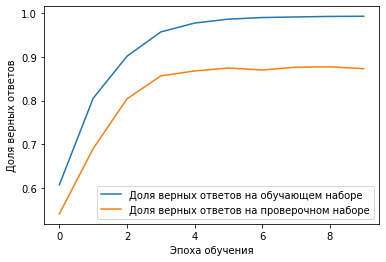

In [0]:
model01 = Sequential()
model01.add(Dense(200, input_dim=20000, activation="relu"))
model01.add(Dropout(0.25))
model01.add(BatchNormalization())
model01.add(Dense(21, activation='sigmoid'))
model01.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = model01.fit(xTrain01, 
                      y_train, 
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest01, y_test))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

#### Итог.

Результат получился даже выше, чем в ноутбуке урока. Попробуем еще несколько архитектур.

### Part II

Epoch 1/10
113/113 [==============================] - 1s 10ms/step - loss: 1.6829 - accuracy: 0.5466 - val_loss: 1.0677 - val_accuracy: 0.7285
Epoch 2/10
113/113 [==============================] - 1s 9ms/step - loss: 0.4965 - accuracy: 0.9006 - val_loss: 0.6776 - val_accuracy: 0.8309
Epoch 3/10
113/113 [==============================] - 1s 9ms/step - loss: 0.1493 - accuracy: 0.9795 - val_loss: 0.5639 - val_accuracy: 0.8505
Epoch 4/10
113/113 [==============================] - 1s 9ms/step - loss: 0.0627 - accuracy: 0.9921 - val_loss: 0.5247 - val_accuracy: 0.8600
Epoch 5/10
113/113 [==============================] - 1s 9ms/step - loss: 0.0385 - accuracy: 0.9944 - val_loss: 0.5286 - val_accuracy: 0.8622
Epoch 6/10
113/113 [==============================] - 1s 9ms/step - loss: 0.0278 - accuracy: 0.9953 - val_loss: 0.5322 - val_accuracy: 0.8613
Epoch 7/10
113/113 [==============================] - 1s 9ms/step - loss: 0.0243 - accuracy: 0.9952 - val_loss: 0.5302 - val_accuracy: 0.8635
Epoch

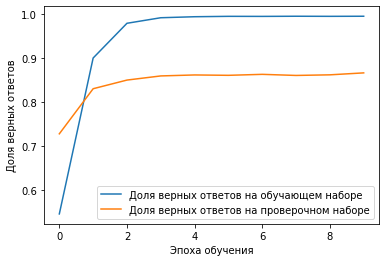

In [0]:
# let's simplify to the maximum

model01 = Sequential()
model01.add(Dense(100, activation='relu', input_dim=20000))
model01.add(Dense(21, activation='softmax'))
model01.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
history = model01.fit(xTrain01, 
                      y_train, 
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest01, y_test))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

Результат почти не изменился.

In [0]:
# complicate a little
model = Sequential()
model.add(Dense(100, activation='linear', input_dim=20000))
model.add(Dropout(0.2))
model.add(Dense(50))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(21, activation='softmax'))
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.fit(xTrain01,
          y_train,
          validation_data=(xTest01, y_test),
          epochs=20,
          batch_size=256,
          verbose=1)

Epoch 1/20
57/57 [==============================] - 1s 20ms/step - loss: 1.6892 - accuracy: 0.5658 - val_loss: 2.0328 - val_accuracy: 0.7050
Epoch 2/20
57/57 [==============================] - 1s 19ms/step - loss: 0.4371 - accuracy: 0.9164 - val_loss: 1.4999 - val_accuracy: 0.8057
Epoch 3/20
57/57 [==============================] - 1s 17ms/step - loss: 0.1580 - accuracy: 0.9787 - val_loss: 1.0597 - val_accuracy: 0.8447
Epoch 4/20
57/57 [==============================] - 1s 18ms/step - loss: 0.0807 - accuracy: 0.9914 - val_loss: 0.7794 - val_accuracy: 0.8497
Epoch 5/20
57/57 [==============================] - 1s 18ms/step - loss: 0.0590 - accuracy: 0.9931 - val_loss: 0.6330 - val_accuracy: 0.8561
Epoch 6/20
57/57 [==============================] - 1s 18ms/step - loss: 0.0424 - accuracy: 0.9938 - val_loss: 0.5743 - val_accuracy: 0.8611
Epoch 7/20
57/57 [==============================] - 1s 18ms/step - loss: 0.0381 - accuracy: 0.9942 - val_loss: 0.5709 - val_accuracy: 0.8635
Epoch 8/20
57

Результат не изменился практически.

Epoch 1/10
113/113 [==============================] - 2s 14ms/step - loss: 1.8370 - accuracy: 0.4735 - val_loss: 2.1101 - val_accuracy: 0.6358
Epoch 2/10
113/113 [==============================] - 1s 11ms/step - loss: 0.7598 - accuracy: 0.7840 - val_loss: 1.1747 - val_accuracy: 0.7991
Epoch 3/10
113/113 [==============================] - 1s 11ms/step - loss: 0.2765 - accuracy: 0.9226 - val_loss: 0.6955 - val_accuracy: 0.8242
Epoch 4/10
113/113 [==============================] - 1s 11ms/step - loss: 0.1273 - accuracy: 0.9651 - val_loss: 0.6667 - val_accuracy: 0.8445
Epoch 5/10
113/113 [==============================] - 1s 10ms/step - loss: 0.0906 - accuracy: 0.9770 - val_loss: 0.7489 - val_accuracy: 0.8420
Epoch 6/10
113/113 [==============================] - 1s 11ms/step - loss: 0.0676 - accuracy: 0.9810 - val_loss: 0.8147 - val_accuracy: 0.8428
Epoch 7/10
113/113 [==============================] - 1s 11ms/step - loss: 0.0516 - accuracy: 0.9863 - val_loss: 0.8478 - val_accuracy: 0.8445

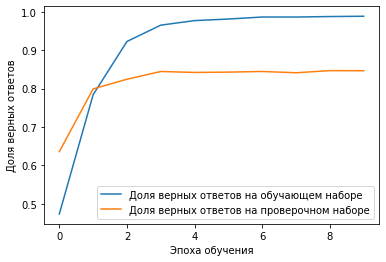

In [0]:
# more complicate
model = Sequential()
model.add(Dense(200, activation='relu', input_dim=20000))
model.add(Dropout(0.2))
model.add(Dense(150, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(150, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(21, activation='softmax'))
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(xTrain01, 
                      y_train, 
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest01, y_test))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

На результат почти не отразилось) Давайте еще одну)

Epoch 1/10
113/113 [==============================] - 2s 15ms/step - loss: 2.5225 - accuracy: 0.3370 - val_loss: 1.9132 - val_accuracy: 0.5389
Epoch 2/10
113/113 [==============================] - 1s 12ms/step - loss: 1.3408 - accuracy: 0.6234 - val_loss: 1.2316 - val_accuracy: 0.6704
Epoch 3/10
113/113 [==============================] - 1s 12ms/step - loss: 0.8791 - accuracy: 0.7516 - val_loss: 0.9197 - val_accuracy: 0.7603
Epoch 4/10
113/113 [==============================] - 1s 12ms/step - loss: 0.5491 - accuracy: 0.8470 - val_loss: 0.8228 - val_accuracy: 0.7960
Epoch 5/10
113/113 [==============================] - 1s 12ms/step - loss: 0.3559 - accuracy: 0.9055 - val_loss: 0.7955 - val_accuracy: 0.8231
Epoch 6/10
113/113 [==============================] - 1s 12ms/step - loss: 0.2342 - accuracy: 0.9361 - val_loss: 0.8138 - val_accuracy: 0.8276
Epoch 7/10
113/113 [==============================] - 1s 12ms/step - loss: 0.1662 - accuracy: 0.9571 - val_loss: 0.8196 - val_accuracy: 0.8320

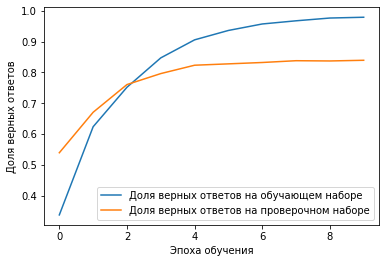

In [0]:
model = Sequential()
model.add(Dense(300, activation='linear', input_dim=20000))
model.add(Dropout(0.4))
model.add(Dense(200))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Flatten())
model.add(Dense(150, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(100, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(21, activation='softmax'))
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(xTrain01, 
                      y_train, 
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest01, y_test))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

Стало даже хуже)

### Part III

Сделаем функцию распознавания новых обращений.

In [0]:
df['category'][44]

'Спорт'

In [0]:
df['text'][44]

'" xxxx Обращаюсь к вам от всего тренерского состава, детей и их родителей СДЮШОРа Металлург. Так уж сложились обстоятельства, что с наступлением холодов нашим воспитанникам негде тренироваться. Бывший губернатор со своими соратниками взорвали замечательный манеж Юбилейный а обещанного нового к сожалению мы не увидели. Во всех соседних областях уже давно ребятишки зимой занимаются в крытом манеже с искусственным полем, мы дожили до того, что в Тамбове открыли футбольный интернат только к сожалению наша область в плане развития детского футбола откатывается назад. Очень сильно просим вас не оставаться безразличным в этой проблеме. С уважением к Вам тренер СДЮШОР. "'

In [0]:
def what_is_category(text):
  global model
  text_in_WordInd_1 = tokenizer.texts_to_sequences([text])
  if len(text_in_WordInd_1[0]) > 100:
    split_text = get_slices(text_in_WordInd_1[0], 100, 50)
  else:
    split_text = text_in_WordInd_1
  split_texts_1 = []
  items = list(tokenizer.word_index.items())
  for num in range(len(split_text)):
    cur_text = split_text[num]
    cur_mes = []
    for i in cur_text:
      char = items[i-1][0]
      cur_mes.append(char)
    split_texts_1.append(cur_mes)
  xTex = tokenizer.texts_to_matrix(split_texts_1) 
  currPred = model.predict(xTex)
  list_pred =[]
  for i in currPred:
    recognizedClass = np.argmax(i)
    list_pred.append(recognizedClass)
  list_pred_set = set(list_pred) 
  dict_count_class = {}
  for i in list_pred_set:
    count = 0
    for j in list_pred:
      if i == j:
        count += 1
    dict_count_class[i]=count
  win_class = 0
  for i in dict_count_class:
    if dict_count_class[i] > win_class:
      win_class = i
  return win_class, encoder.inverse_transform([win_class])[0]

In [0]:
print(what_is_category(df['text'][44]))

(16, 'Спорт')


### Part IV

Попробуем другой вид фильтрации. А именно удалим все запросы, в которых количество символов меньше 40, как не несущих смысла или неполных.

In [0]:
texts = df['text'].values
classes = list(df['category'].values)
texts_clean = []
class_clean = []
min_con = 40

for i in range(len(texts)):
  if len(texts[i]) > min_con:
    texts_clean.append(texts[i])
    class_clean.append(classes[i])

In [0]:
maxWordsCount = 20000
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(texts_clean)
X = tokenizer.texts_to_sequences(texts_clean)

In [0]:
encoder = LabelEncoder()
encoder.fit(class_clean)
classesEncoded = encoder.transform(class_clean) #кодируем категории
yAll = utils.to_categorical(classesEncoded, len(set(classes)))

In [0]:
slice_len = 100
step = 50

x_new, y_new = create_ds(X, yAll, slice_len, step)
print(x_new.shape, y_new.shape)
x_train, x_test, y_train, y_test = train_test_split(x_new, y_new, test_size=0.2)
xTrain01 = tokenizer.sequences_to_matrix(x_train.tolist())
xTest01 = tokenizer.sequences_to_matrix(x_test.tolist())
xTrain01.shape

(18065,) (18065, 21)


(14452, 20000)

Epoch 1/10
113/113 [==============================] - 1s 11ms/step - loss: 1.5313 - accuracy: 0.5987 - val_loss: 1.6334 - val_accuracy: 0.7393
Epoch 2/10
113/113 [==============================] - 1s 11ms/step - loss: 0.3390 - accuracy: 0.9340 - val_loss: 0.8231 - val_accuracy: 0.8431
Epoch 3/10
113/113 [==============================] - 1s 11ms/step - loss: 0.1133 - accuracy: 0.9846 - val_loss: 0.5857 - val_accuracy: 0.8580
Epoch 4/10
113/113 [==============================] - 1s 10ms/step - loss: 0.0671 - accuracy: 0.9907 - val_loss: 0.5689 - val_accuracy: 0.8550
Epoch 5/10
113/113 [==============================] - 1s 10ms/step - loss: 0.0450 - accuracy: 0.9932 - val_loss: 0.5792 - val_accuracy: 0.8572
Epoch 6/10
113/113 [==============================] - 1s 11ms/step - loss: 0.0441 - accuracy: 0.9934 - val_loss: 0.6033 - val_accuracy: 0.8583
Epoch 7/10
113/113 [==============================] - 1s 10ms/step - loss: 0.0381 - accuracy: 0.9939 - val_loss: 0.5946 - val_accuracy: 0.8583

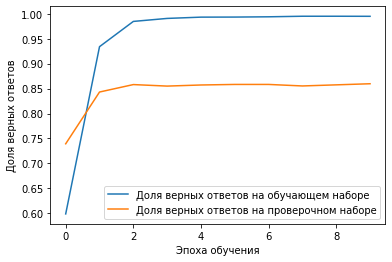

In [0]:
# возьмем ту же самую нейроночку
# complicate a little
model = Sequential()
model.add(Dense(100, activation='linear', input_dim=20000))
model.add(Dropout(0.2))
model.add(Dense(50))
model.add(LeakyReLU(alpha=0.2))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(21, activation='softmax'))
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

history = model.fit(xTrain01, 
                      y_train, 
                      epochs=10,
                      batch_size=128,
                      validation_data=(xTest01, y_test))

plt.plot(history.history['accuracy'], 
         label='Доля верных ответов на обучающем наборе')
plt.plot(history.history['val_accuracy'], 
         label='Доля верных ответов на проверочном наборе')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

К сожалению, это не принесло улучшения результатов.

### Part V

Я бы сказал, что на данной неделе главный вывод для меня - что качество данных намного важнее, чем архитектура нейросети. Сбалансированность данных, наличие достаточного количества примеров похожих на любой вариант в проверочной выборке.